## Project: Wildfire Destructive Potential Index 

### Module 5: *Evaluation and Visualization*

---
### Contents  
- 1. Generate Case Study Predictions
- 2. Geospatial Visualization
---
### Notes
This section applies the trained models to predict wildfire severity in two real-world scenarios:

#### Palisades Fire (January 2025)  
#### Dixie Fire (July 2021)

We evaluate and compare the performance of three classification models:

- **XGBoost** (multi-class classification)
- **Random Forest**
- **K-Nearest Neighbors (KNN)**
---
### Inputs

---
### Outputs  

---
### User Created Dependencies  

In [1]:
# Add the parent directory to the system path so "src" can be found
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

# user built utilities
from src.plot_utils import plot_map
from src.plot_utils import individual_plot_map
from src.plot_utils import interpolate_idw

---
### Third Party Dependencies

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifier

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.lines as mlines  # For custom map legends

from datetime import timedelta

In [3]:
# Features and labels
X = pd.read_csv('../data/processed/X.csv')
y = pd.read_csv('../data/processed/y.csv').squeeze()  # Load as Series

pal_X = pd.read_csv('../data/processed/pal_X.csv')
dixie_X = pd.read_csv('../data/processed/dixie_X.csv')

# Prediction detail files for Palisades and Dixie fires
pal_details = pd.read_csv("../data/processed/pal_details.csv", parse_dates=["Date"])
dixie_details = pd.read_csv("../data/processed/dixie_details.csv", parse_dates=["Date"])

climates = pd.read_csv('../data/raw/California_Counties_Climate_Zones.csv')
final = pd.read_csv("../data/processed/merged_weather_fire.csv", parse_dates=['Date'])

In [4]:
# Sample 2,000 'Low' cases
low_indices = y[y == 0].sample(n=7000, random_state=42).index

# Get all 'Moderate' and 'High' indices
other_indices = y[y != 0].index

# Combine sampled 'Low' with all others
final_indices = low_indices.union(other_indices)

# Subset X and y
X = X.loc[final_indices].reset_index(drop=True)
y = y.loc[final_indices].reset_index(drop=True)

---

## 1 Generate Case Study Predictions

In [5]:
# Manual encoding
label_map = {0: "Low", 1: "Moderate", 2: "High"}
y_encoded = y.map(label_map)

# Reverse map for decoding later
reverse_map = {v: k for k, v in label_map.items()}

### 1.1 Build Models

In [6]:
model_parameters = pd.read_csv('../data/processed/model_parameters.csv', index_col=0)
RF_parameters = model_parameters.loc['RandomForest'].dropna().to_dict()
XGB_parameters = model_parameters.loc['XGBoost'].dropna().to_dict()
Knn_parameters = model_parameters.loc['KNN'].dropna().to_dict()

In [7]:
optimal_learning_rate = XGB_parameters['learning_rate']

In [8]:
# Helper function to convert to int if possible
def convert_to_int(d):
    return {k: int(float(v)) if str(v).replace('.', '', 1).isdigit() else v for k, v in d.items()}

RF_parameters = convert_to_int(RF_parameters)
XGB_parameters = convert_to_int(XGB_parameters)
Knn_parameters = convert_to_int(Knn_parameters)


In [9]:
XGB_parameters['learning_rate'] = optimal_learning_rate

In [10]:
display(RF_parameters)
display(XGB_parameters)
display(Knn_parameters)

{'n_estimators': 50,
 'max_depth': 20,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'class_weight': 'balanced'}

{'n_estimators': 200,
 'max_depth': 6,
 'objective': 'multi:softmax',
 'num_class': 3,
 'learning_rate': 0.4}

{'n_neighbors': 4, 'weights': 'distance'}

In [11]:
# Final tuned models
optimum_xgb_model = xgb.XGBClassifier(**XGB_parameters)
optimum_rf = RandomForestClassifier(**RF_parameters)
optimum_knn = KNeighborsClassifier(**Knn_parameters)

### 1.2 Train Models

In [12]:
# Fit models on full training data
optimum_xgb_model.fit(X, y)
optimum_rf.fit(X, y)
optimum_knn.fit(X, y)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [13]:
rf_importances = optimum_rf.feature_importances_
for name, importance in zip(X.columns, rf_importances):
    print(f"{name}: {importance:.4f}")

Mean Income: 0.0435
Total Population x Mean Income: 0.0541
Avg Rel Hum (%): 0.0369
Avg Air Temp (F): 0.0491
ETo (in): 0.0367
Elevation: 0.0746
Avg Soil Temp (F): 0.0783
Size (square miles): 0.0628
Sol Rad (Ly/day): 0.0587
density: 0.0551
Total Population x Size (square miles): 0.0379
Avg Rel Hum (%) x Elevation: 0.0420
Avg Air Temp (F) x Avg Soil Temp (F): 0.0511
Size (square miles) x Mean Income: 0.0486
Total Population x density: 0.0836
Avg Vap Pres (mBars) x Elevation: 0.0500
ETo (in) x Avg Air Temp (F): 0.0432
Precip (in): 0.0091
Avg Vap Pres (mBars) x Avg Air Temp (F): 0.0421
Avg Wind Speed (mph) x Mean Income: 0.0424


In [14]:
xgb_importances = optimum_xgb_model.feature_importances_
for name, importance in zip(X.columns, xgb_importances):
    print(f"{name}: {importance:.4f}")

Mean Income: 0.0955
Total Population x Mean Income: 0.0462
Avg Rel Hum (%): 0.0174
Avg Air Temp (F): 0.0181
ETo (in): 0.0216
Elevation: 0.0474
Avg Soil Temp (F): 0.0323
Size (square miles): 0.2580
Sol Rad (Ly/day): 0.0219
density: 0.1070
Total Population x Size (square miles): 0.0458
Avg Rel Hum (%) x Elevation: 0.0196
Avg Air Temp (F) x Avg Soil Temp (F): 0.0186
Size (square miles) x Mean Income: 0.0301
Total Population x density: 0.1338
Avg Vap Pres (mBars) x Elevation: 0.0187
ETo (in) x Avg Air Temp (F): 0.0175
Precip (in): 0.0148
Avg Vap Pres (mBars) x Avg Air Temp (F): 0.0178
Avg Wind Speed (mph) x Mean Income: 0.0178


from sklearn.inspection import permutation_importance

result = permutation_importance(optimum_knn, X, y, n_repeats=10, random_state=42)

for name, importance in zip(X_val.columns, result.importances_mean):
    print(f"{name}: {importance:.4f}")

### 1.3 Generate Predictions

In [15]:
# Palisades Fire (January 2025)
pal_xgb_predictions = pd.DataFrame(optimum_xgb_model.predict(pal_X))
pal_rf_predictions = pd.DataFrame(optimum_rf.predict(pal_X))
pal_knn_predictions = pd.DataFrame(optimum_knn.predict(pal_X))


# Dixie Fire (July 2021)
dixie_xgb_predictions = pd.DataFrame(optimum_xgb_model.predict(dixie_X))
dixie_rf_predictions = pd.DataFrame(optimum_rf.predict(dixie_X))
dixie_knn_predictions = pd.DataFrame(optimum_knn.predict(dixie_X))


In [16]:
# Apply reverse mapping to all prediction sets
pal_xgb_predictions[0] = pal_xgb_predictions[0].replace(label_map)
pal_rf_predictions[0] = pal_rf_predictions[0].replace(label_map)
pal_knn_predictions[0] = pal_knn_predictions[0].replace(label_map)


dixie_xgb_predictions[0] = dixie_xgb_predictions[0].replace(label_map)
dixie_rf_predictions[0] = dixie_rf_predictions[0].replace(label_map)
dixie_knn_predictions[0] = dixie_knn_predictions[0].replace(label_map)


### 1.4 Decode and Merge Results

In [17]:
pal_details['Prediction XGB'] = pal_xgb_predictions[0].values
pal_details['Prediction KNN'] = pal_knn_predictions[0].values
pal_details['Prediction RF']  = pal_rf_predictions[0].values


dixie_details['Prediction XGB'] = dixie_xgb_predictions[0].values
dixie_details['Prediction KNN'] = dixie_knn_predictions[0].values
dixie_details['Prediction RF']  = dixie_rf_predictions[0].values


### 1.5 Filter Prediction Data by Fire Dates

In [18]:
pal_specific_date = pd.to_datetime('2025-01-07')
dixie_specific_date = pd.to_datetime('2021-07-13')
pal_specific_date_end = pd.to_datetime('2025-01-12')

pal_predictions = pal_details[pal_details['Date'] == pal_specific_date]
dixie_predictions = dixie_details[dixie_details['Date'] == dixie_specific_date]

In [19]:
forward = timedelta(days = 1)
pal_specific_date + forward

Timestamp('2025-01-08 00:00:00')

### 1.6 Convert to GeoDataFrames

In [20]:
# Create geometry from lat/lon
pal_geometry = [Point(xy) for xy in zip(pal_predictions['Longitude'], pal_predictions['Latitude'])]
dixie_geometry = [Point(xy) for xy in zip(dixie_predictions['Longitude'], dixie_predictions['Latitude'])]

# Convert to GeoDataFrames
pal_gdf = gpd.GeoDataFrame(pal_predictions, geometry=pal_geometry, crs="EPSG:4326")
dixie_gdf = gpd.GeoDataFrame(dixie_predictions, geometry=dixie_geometry, crs="EPSG:4326")

## 2 Geospatial Visualization of Model Predictions

This section visualizes wildfire severity predictions made by each model on specific dates during the Palisades Fire (Jan 2025) and the Dixie Fire (July 2021).

### 2.1 Palisades + Eaton Fire Predictions

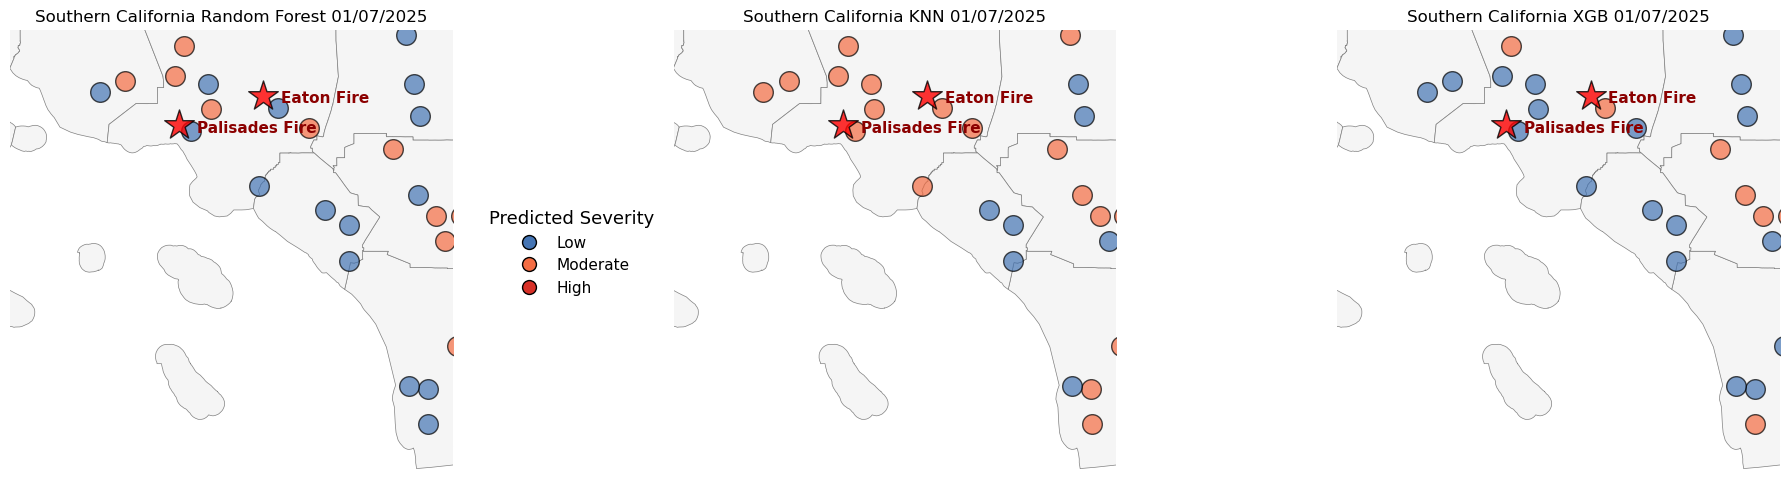

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot into each subplot by passing in the axis
plot_map(pal_gdf, 'Prediction RF', 'Pal', ax=axes[0])
plot_map(pal_gdf, 'Prediction KNN', 'Pal', ax=axes[1])
plot_map(pal_gdf, 'Prediction XGB', 'Pal', ax=axes[2])

# Set titles if plot_map doesn't do it
axes[0].set_title('Southern California Random Forest 01/07/2025')
axes[1].set_title('Southern California KNN 01/07/2025')
axes[2].set_title('Southern California XGB 01/07/2025')

plt.tight_layout()

plt.savefig("../plots/Palisades_predictions.png", dpi=300)

### 2.2 Dixie Fire Predictions

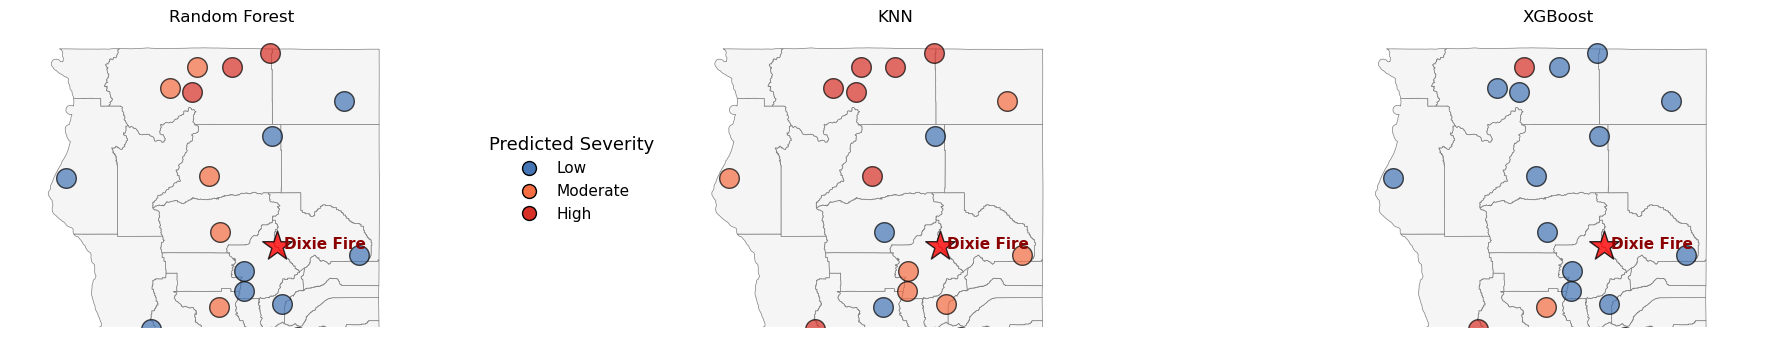

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot into each subplot by passing in the axis
plot_map(dixie_gdf, 'Prediction RF', 'Dixie', ax=axes[0])
plot_map(dixie_gdf, 'Prediction KNN', 'Dixie', ax=axes[1])
plot_map(dixie_gdf, 'Prediction XGB', 'Dixie', ax=axes[2])

# Set titles if plot_map doesn't do it
axes[0].set_title('Random Forest')
axes[1].set_title('KNN')
axes[2].set_title('XGBoost')

plt.tight_layout()
plt.show()

### 2.3 California

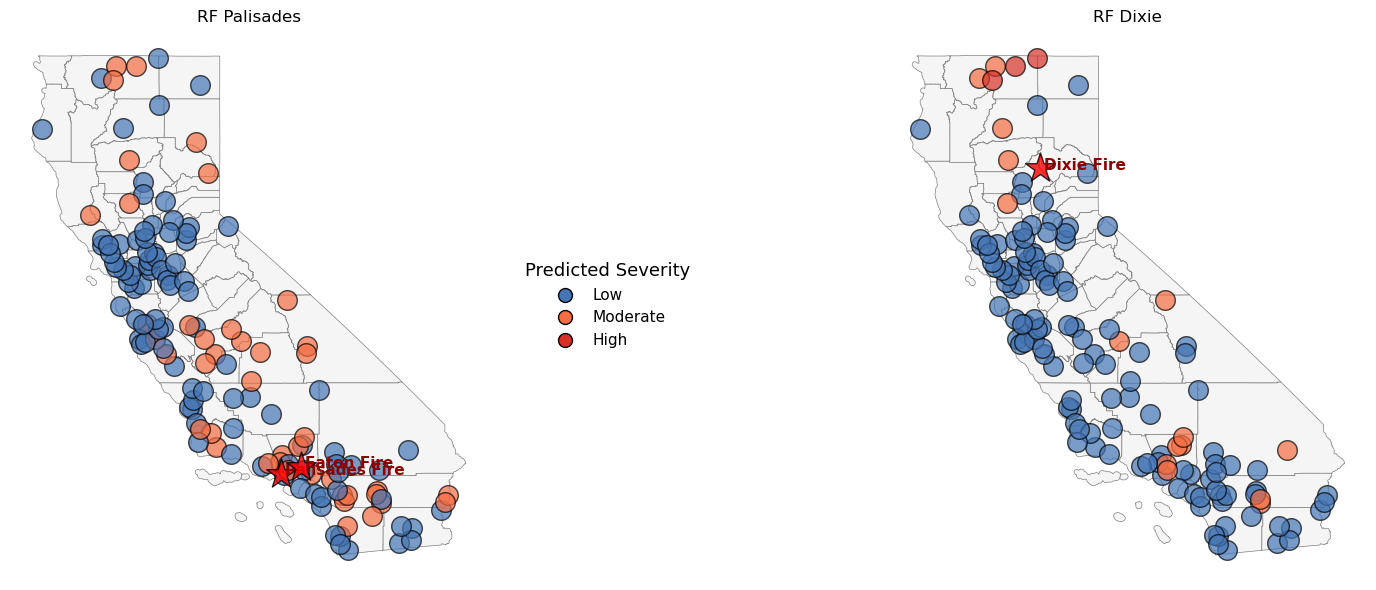

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

# Plot into each subplot by passing in the axis
plot_map(pal_gdf, 'Prediction RF', 'Pal Cali', ax=axes[0])
plot_map(dixie_gdf, 'Prediction RF', 'Dixie Cali', ax=axes[1])

# Set titles if plot_map doesn't do it
axes[0].set_title('RF Palisades')
axes[1].set_title('RF Dixie')

plt.tight_layout()
plt.show()

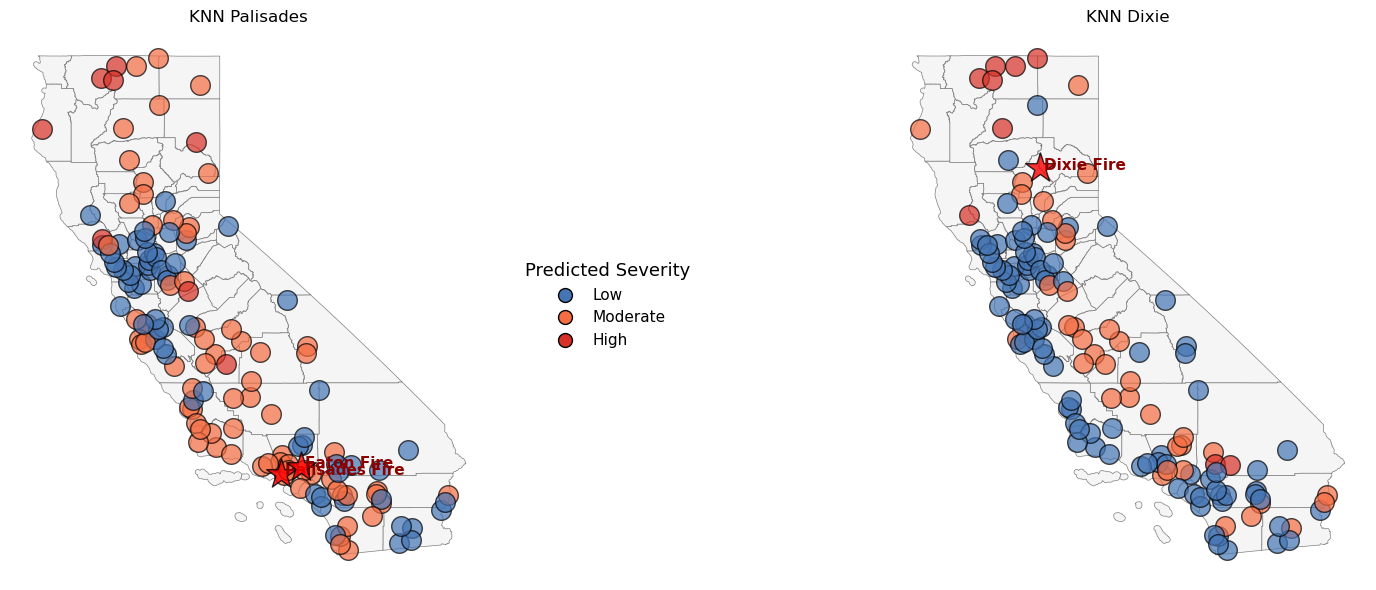

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

# Plot into each subplot by passing in the axis
plot_map(pal_gdf, 'Prediction KNN', 'Pal Cali', ax=axes[0])
plot_map(dixie_gdf, 'Prediction KNN', 'Dixie Cali', ax=axes[1])

# Set titles if plot_map doesn't do it
axes[0].set_title('KNN Palisades')
axes[1].set_title('KNN Dixie')

plt.tight_layout()
plt.show()

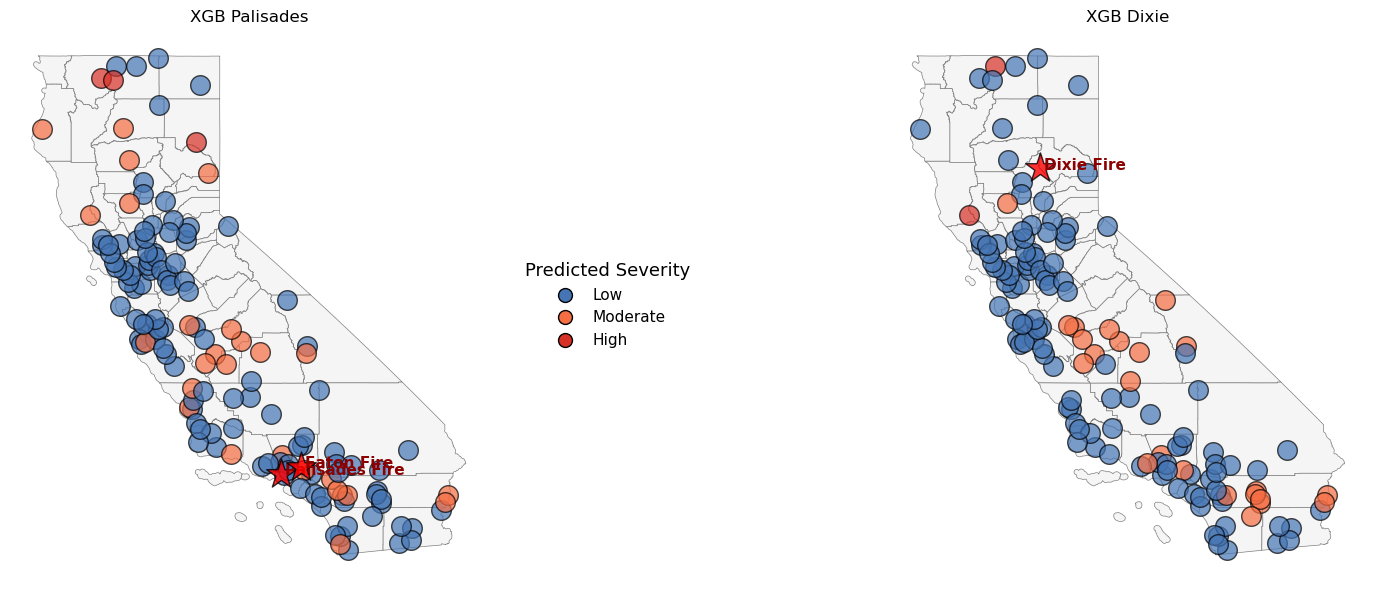

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

# Plot into each subplot by passing in the axis
plot_map(pal_gdf, 'Prediction XGB', 'Pal Cali', ax=axes[0])
plot_map(dixie_gdf, 'Prediction XGB', 'Dixie Cali', ax=axes[1])

# Set titles if plot_map doesn't do it
axes[0].set_title('XGB Palisades')
axes[1].set_title('XGB Dixie')

plt.tight_layout()
plt.show()

In [26]:
c_map = {'Low':0,'Moderate':1,'High':2} 
pred_cols = ['Prediction KNN','Prediction RF','Prediction XGB']
loc_cols = ['Pal','Dixie']

In [27]:
for col in pred_cols:
    pal_gdf[col] = pal_gdf[col].map(c_map)
    
for col in pred_cols:
    dixie_gdf[col] = dixie_gdf[col].map(c_map)

In [28]:
pal_gdf['firename'] = 'Pal'
dixie_gdf['firename'] = 'Dixie'
combined_gdf = gpd.GeoDataFrame(pd.concat([pal_gdf, dixie_gdf], ignore_index=True), crs=pal_gdf.crs)
gdf = combined_gdf[combined_gdf['firename'] == 'Pal']


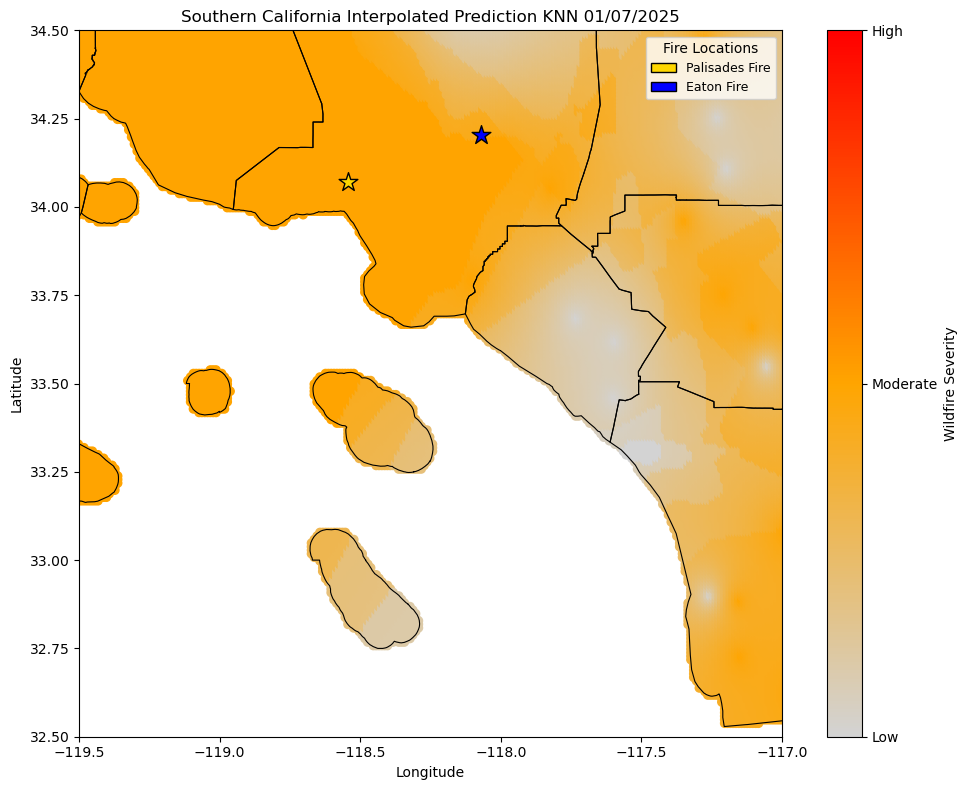

In [29]:
interpolated = interpolate_idw(gdf_points = gdf, value_column = 'Prediction KNN', k = 5, grid_spacing = 0.01,
                               buffer = 0.1, firename = 'Pal', crop = True, 
                               title = 'Southern California Interpolated Prediction XGB - 01/07/2025',
                               plot = True)